In [1]:
import pandas as pd
import os

RAW_PATH = "../data/raw/suicide-rate-who-mdb.csv"  # <-- change to the real path you found
raw = pd.read_csv(RAW_PATH)

# detect the rate column (the long one)
rate_col = [c for c in raw.columns if c not in ["Entity","Code","Year"]][0]

df = raw.rename(columns={
    "Entity": "country",
    "Code": "iso3",
    "Year": "year",
    rate_col: "suicide_rate"
})

df["year"] = pd.to_numeric(df["year"], errors="coerce")
df["suicide_rate"] = pd.to_numeric(df["suicide_rate"], errors="coerce")
df = df.dropna(subset=["country","year","suicide_rate"])

df["year"] = df["year"].astype(int)

os.makedirs("../reports", exist_ok=True)

# Save the real cleaned dataset (wide)
df.to_csv("../reports/cleaned.csv", index=False)

# Table 1
table1 = df[["country","iso3","year","suicide_rate"]].sort_values(["country","year"])
table1.to_csv("../reports/suicide_rate_year_country.csv", index=False)

# Table 2
latest_year = int(table1["year"].max())
table2 = (table1[table1["year"] == latest_year]
          .sort_values("suicide_rate", ascending=False))
table2.to_csv("../reports/suicide_rate_top_countries_latest.csv", index=False)

# Table 3
last_two = (table1.sort_values(["country","year"])
            .groupby("country")
            .tail(2))

table3 = (last_two.groupby("country")
          .apply(lambda g: pd.Series({
              "year_prev": g["year"].iloc[0] if len(g) == 2 else None,
              "rate_prev": g["suicide_rate"].iloc[0] if len(g) == 2 else None,
              "year_latest": g["year"].iloc[-1],
              "rate_latest": g["suicide_rate"].iloc[-1],
          }))
          .reset_index())

table3["delta"] = table3["rate_latest"] - table3["rate_prev"]
table3 = table3.sort_values("rate_latest", ascending=False)
table3.to_csv("../reports/suicide_rate_summary_latest.csv", index=False)

print("DONE. Reports now has:", os.listdir("../reports"))
print("Latest year:", latest_year)
table1.head()


DONE. Reports now has: ['cleaned.csv', 'suicide_rate_year_country.csv', 'suicide_rate_top_countries_latest.csv', 'suicide_rate_summary_latest.csv']
Latest year: 2023


/var/folders/cn/dlgcdqs952b1y1t9_z8r5d7r0000gn/T/ipykernel_15570/2119181290.py:44: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,country,iso3,year,suicide_rate
0,Albania,ALB,1987,2.474300
1,Albania,ALB,1988,2.234553
2,Albania,ALB,1989,2.352273
3,Albania,ALB,1992,1.604659
4,Albania,ALB,1993,2.503264


In [2]:
import pandas as pd
table1 = pd.read_csv("../reports/suicide_rate_year_country.csv")
table2 = pd.read_csv("../reports/suicide_rate_top_countries_latest.csv")
table3 = pd.read_csv("../reports/suicide_rate_summary_latest.csv")
table1.head()


,country,iso3,year,suicide_rate
0,Albania,ALB,1987,2.474300
1,Albania,ALB,1988,2.234553
2,Albania,ALB,1989,2.352273
3,Albania,ALB,1992,1.604659
4,Albania,ALB,1993,2.503264


Matplotlib is building the font cache; this may take a moment.


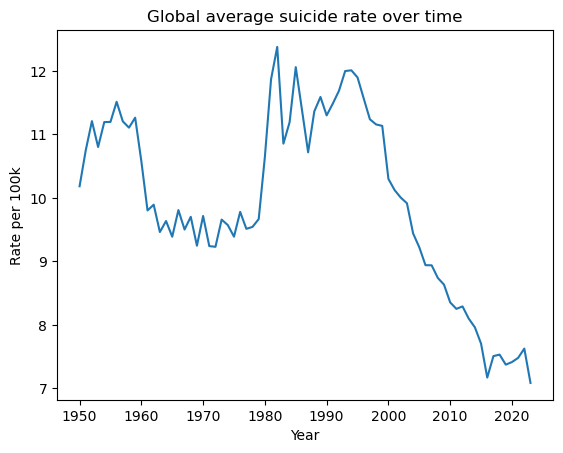

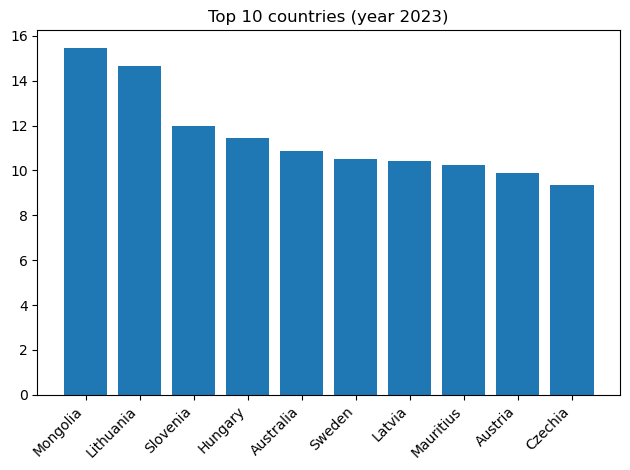

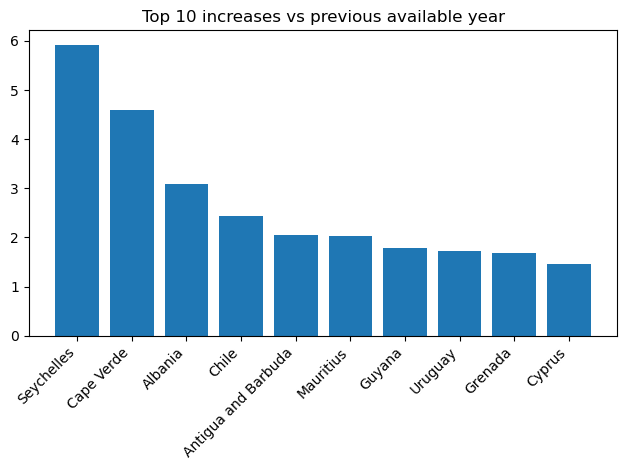

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

table1 = pd.read_csv("../reports/suicide_rate_year_country.csv")
table2 = pd.read_csv("../reports/suicide_rate_top_countries_latest.csv")
table3 = pd.read_csv("../reports/suicide_rate_summary_latest.csv")

# 1) Global mean trend
global_year = table1.groupby("year", as_index=False)["suicide_rate"].mean()
plt.figure()
plt.plot(global_year["year"], global_year["suicide_rate"])
plt.xlabel("Year"); plt.ylabel("Rate per 100k")
plt.title("Global average suicide rate over time")
plt.show()

# 2) Top 10 latest-year
top10 = table2.head(10)
plt.figure()
plt.bar(top10["country"], top10["suicide_rate"])
plt.xticks(rotation=45, ha="right")
plt.title(f"Top 10 countries (year {int(table2['year'].max())})")
plt.tight_layout()
plt.show()

# 3) Biggest increases vs previous available year
top_inc = (table3.dropna(subset=["delta"])
           .sort_values("delta", ascending=False)
           .head(10))
plt.figure()
plt.bar(top_inc["country"], top_inc["delta"])
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 increases vs previous available year")
plt.tight_layout()
plt.show()
